In [1]:
# import packages
import numpy as np
import seaborn as sns
from scipy.stats import wishart, dirichlet, expon
import scipy.special as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
def data_generator(alpha, b, para_topic, T, N):
    
    mu0, lambda0, W, nu = para_topic
    
    nlabel = len(T)
    dg = len(alpha)
    ntopic = len(T[0])
    d = len(mu0)
    
    # generate the corpus-level variables
    rho = np.random.dirichlet(alpha, 1)[0]
    a = np.random.exponential(1/b,1)[0]
    
    # generate topics
    s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
    mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])
#     mu = mu*10
    
    s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
    tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu
    
    # generate document
    Y = np.random.choice(list(range(nlabel)),N) # labels
    G = np.random.dirichlet(a*rho,N)
    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])

    X = []
    
    for i in range(N):
        tems = np.linalg.inv(np.dot(s2.T, U[i]).reshape(d,d)) # sum_j(u_j * sigma_j^-1), sigma(x) 
        t2 = np.dot(tao.T, U[i]) # sum_j(u_j * tao_j)
        temmu = np.dot(tems, t2) # mu(x)
        tem = np.random.multivariate_normal(temmu, tems)
        X.append(tem)
    X = np.array(X)

    return rho, a, X, Y, U, G, s_inv, mu

In [20]:
# gibbs_g: given T, rho,a and Theta, recover g
def gibbs_g(X, Y, T, rho, a, s_inv, mu, G, mtime, desired_error):
    '''
    G: ture value of membership score
    mtime: maximum iteration time
    desired_error: desired error of G
    
    output: (G1, arate,error)
    G1: the final estimate
    arate: a list of average accept rate
    error: a list of average estimation error
    '''
    def p1(x, s_inv, mu):
    # return - (x-mu)^T s_inv (x-mu)/2
        return -0.5*np.dot(np.dot((x-mu).T, s_inv), x-mu)
    
    nlabel = len(T)
    dg = len(rho)
    ntopic = len(T[0])
    d = len(mu[0])
    N = len(Y)
    
    count = 0 # number of updates
    
    infinity = 2**(-32)
    
    s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv
    tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)])
    
    # initialization
    G1 = np.random.dirichlet(np.ones(dg), N)
    
    error = [] # store the error of G 
    arate = [] # store the accept rate of the proposed g
    t = 0
    tem = 1
    count = 1
    mtime //= 100 
    while tem > desired_error and t<mtime:
        # if (we get the desired error) or (iteration times > mtime): break
        count = 0
        for tt in range(100):
            for i in range(N):
                newg = np.random.dirichlet(a*rho, 1)[0] # propose g_i~Dir(a*rho)
                if newg.min()<infinity: continue
                newu = np.dot(T[Y[i]], newg)
                tems_inv = np.dot(s2.T, newu).reshape(d,d)
                tems = np.linalg.inv(tems_inv)
                t2 = np.dot(tao.T, newu)
                temmu = np.dot(tems, t2)
    #             try:
                newp = p1(X[i],tems_inv, temmu) 
    #             except:

                oldg = G1[i]
                oldu = np.dot(T[Y[i]], oldg)
                tems_inv = np.dot(s2.T, oldu).reshape(d,d)
                tems = np.linalg.inv(tems_inv)
                t2 = np.dot(tao.T, oldu)
                temmu = np.dot(tems, t2)
                oldp = p1(X[i],tems_inv, temmu) 
                
                ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
                u = np.random.uniform()
                if u < ag:
                    count += 1
                    G1[i] = newg
                    
        arate.append(count/100/N)
        tem = sum(abs(G-G1))/N
        tem = sum(tem)
        error.append(tem)
        t += 1

    
    return G1, arate,error

In [7]:
def fixT(k0, k1, nlabel, alpha, b, para_topic, d, N, mtime, desired_error, draw_plot=0):
    dg = k0 + k1 
    ntopic = nlabel*k0+k1
    T = []
    for i in range(nlabel):
        tem = np.block([
            [np.zeros((k0*i,k0+k1))],
            [np.eye(k0), np.zeros((k0, k1))],
            [np.zeros((k0*(nlabel-i-1),k0+k1))],
            [np.zeros((k1,k0)), np.eye(k1)]
        ])
        T.append(tem)

    rho, a, X, Y, U, G, s_inv, mu = data_generator(alpha, b, para_topic, T, N)

    
    G_hat, a_rate, errors = gibbs_g(X, Y, T, rho, a, s_inv, mu, G, mtime, desired_error)
    
    print("average error of g is:", errors[-1])
    if draw_plot:
        fig1 = plt.figure()
        ax = Axes3D(fig1)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c =Y)
        plt.title("data visualization")
        plt.show()
        U1 = np.array([np.dot(T[Y[i]], G_hat[i]) for i in range(N)])
        estimateU = sns.heatmap(np.dot(U1,U1.T))
        plt.title("estimated membership")
        plt.show()
        trueU = sns.heatmap(np.dot(U,U.T))
        plt.title("true membership")
        plt.show()
        time = len(a_rate)
        plt.scatter([i*100 for i in range(1, time+1)], errors)
        plt.title("estimation error")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_rate)
        plt.title("accept rate")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()

In [22]:
d = 10
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 0.1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 10, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 5, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(5, 5, 5, np.ones(10), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)

average error of g is: 0.1901215686061029
average error of g is: 1.0076980988560127
average error of g is: 0.41383360276336983
average error of g is: 1.3174837460460103
average error of g is: 0.5378114986628607
average error of g is: 1.7738890248620118


In [23]:
d = 20
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 0.1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 10, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 5, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(5, 5, 5, np.ones(10), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)


average error of g is: 1.5972162876949207
average error of g is: 0.2880465734679736
average error of g is: 0.3647225566714893
average error of g is: 1.6984169202808972
average error of g is: 0.20137787523832668
average error of g is: 1.6776850854063854


In [24]:
d = 30
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 0.1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 10, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# fixT(2, 5, 5, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# fixT(5, 5, 5, np.ones(10), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)

average error of g is: 0.24621244961193922
average error of g is: 0.25384806948408545
average error of g is: 0.3659365422045098
average error of g is: 1.73686134278693


In [25]:
d = 40
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 0.1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 10, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# fixT(2, 5, 5, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# fixT(5, 5, 5, np.ones(10), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)

average error of g is: 0.2528146671800389
average error of g is: 1.612699610975552
average error of g is: 0.24426602227248578
average error of g is: 1.5893280999032682


In [21]:
d = 50
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 0.1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
fixT(2, 5, 3, np.ones(7), 10, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)

average error of g is: 0.20443703054764145
average error of g is: 0.12663987707887772
average error of g is: 0.28291116025485796
average error of g is: 1.2860467016134347


average error of g is: 0.1259982843957165


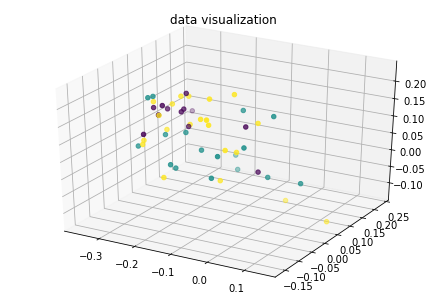

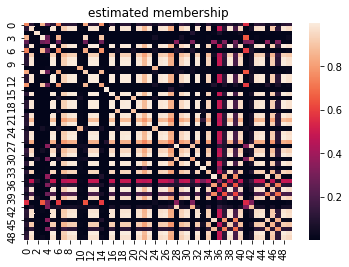

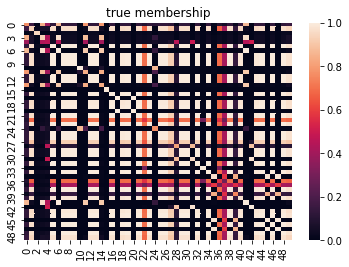

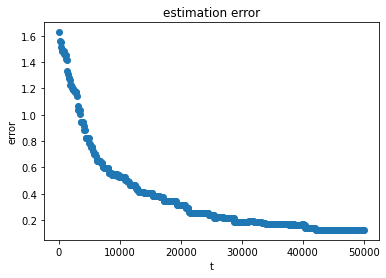

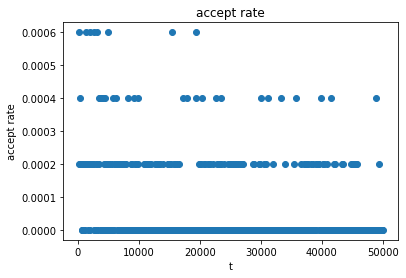

In [30]:
d = 30
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 50000, 0.01, 1)

average error of g is: 0.1958647871136937


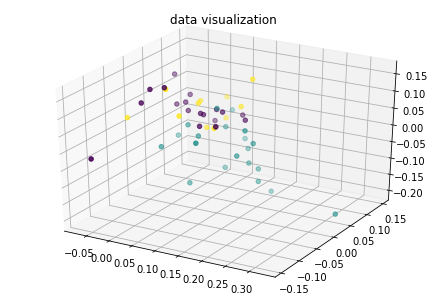

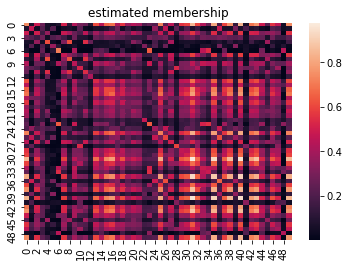

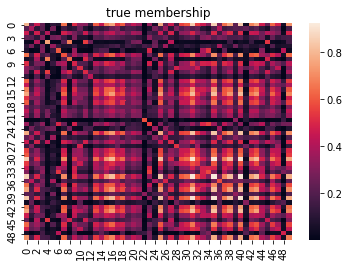

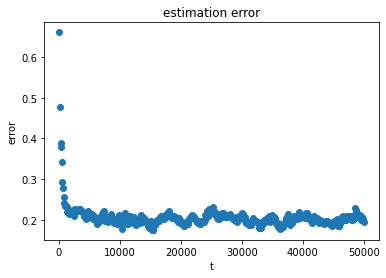

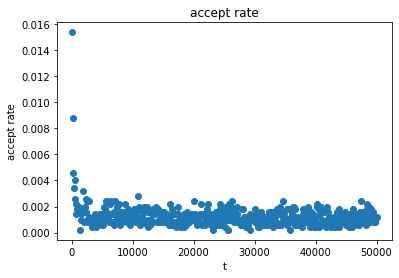

In [32]:
d = 30
fixT(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 50000, 0.01, 1)

In [33]:
def randomT(dg, ntopic, nlabel, alpha, b, para_topic, d, N, mtime, desired_error, draw_plot=0):    
    T = []
    for i in range(nlabel):
        tem = np.random.rand(ntopic,dg)
        for j in range(dg):
            tem[:,j] *= 1/sum(tem[:,j])
        T.append(tem)

    rho, a, X, Y, U, G, s_inv, mu = data_generator(alpha, b, para_topic, T, N)

    
    G_hat, a_rate, errors = gibbs_g(X, Y, T, rho, a, s_inv, mu, G, mtime, desired_error)
    
    print("average error of g is:", errors[-1])
    if draw_plot:
        fig1 = plt.figure()
        ax = Axes3D(fig1)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c =Y)
        plt.title("data visualization")
        plt.show()
        U1 = np.array([np.dot(T[Y[i]], G_hat[i]) for i in range(N)])
        estimateU = sns.heatmap(np.dot(U1,U1.T))
        plt.title("estimated membership")
        plt.show()
        trueU = sns.heatmap(np.dot(U,U.T))
        plt.title("true membership")
        plt.show()
        time = len(a_rate)
        plt.scatter([i*100 for i in range(1, time+1)], errors)
        plt.title("estimation error")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_rate)
        plt.title("accept rate")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()

In [34]:
#randomT(dg, ntopic, nlabel, alpha, b, para_topic, d, N, mtime, desired_error, draw_plot=0)
d = 20
para_topic = [np.zeros(d),0.1,np.eye(d)/3*d, 3*d]
randomT(7, 11, 3, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 20, 3, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 15, 5, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 11, 5, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 11, 3, np.ones(7), 10, para_topic, d, 50, 5000, 0.01)
randomT(7, 11, 3, np.ones(7), 0.1, para_topic, d, 50, 5000, 0.01)

average error of g is: 1.1037891895906833
average error of g is: 1.0553313277321823
average error of g is: 1.673216454555135
average error of g is: 0.9779902954695054
average error of g is: 1.6780887450203705
average error of g is: 0.5486016245037995


In [35]:
#randomT(dg, ntopic, nlabel, alpha, b, para_topic, d, N, mtime, desired_error, draw_plot=0)
d = 30
para_topic = [np.zeros(d),0.1,np.eye(d)/3*d, 3*d]
randomT(7, 11, 3, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 20, 3, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 15, 5, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 11, 5, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 11, 3, np.ones(7), 10, para_topic, d, 50, 5000, 0.01)
randomT(7, 11, 3, np.ones(7), 0.1, para_topic, d, 50, 5000, 0.01)

average error of g is: 1.5889857716504114
average error of g is: 0.9954157580640233
average error of g is: 0.9683385009653442
average error of g is: 0.891223946750359
average error of g is: 1.68856112845345
average error of g is: 0.5152827469060421


In [37]:
#randomT(dg, ntopic, nlabel, alpha, b, para_topic, d, N, mtime, desired_error, draw_plot=0)
d = 40
para_topic = [np.zeros(d),0.1,np.eye(d)/3*d, 3*d]
randomT(7, 11, 3, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 20, 3, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 15, 5, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)
randomT(7, 11, 5, np.ones(7), 1, para_topic, d, 50, 5000, 0.01)


average error of g is: 0.7697876963193766
average error of g is: 1.043385733134706
average error of g is: 0.8633982117356703
average error of g is: 0.7967143471263956


average error of g is: 1.0680755846579733


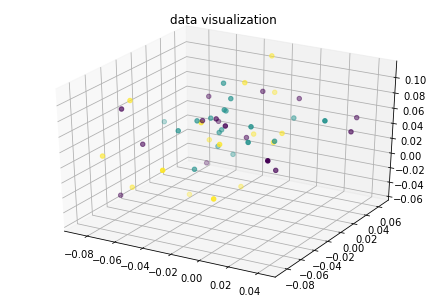

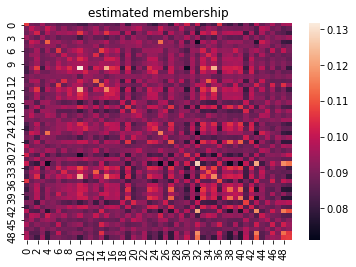

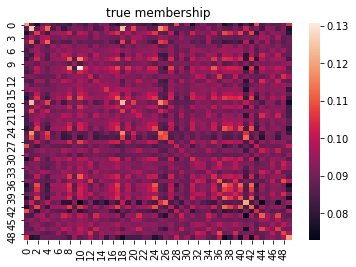

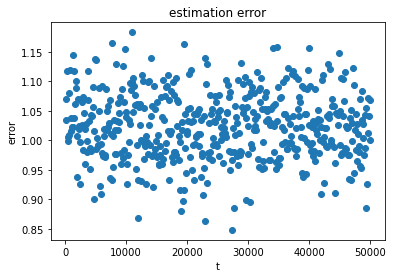

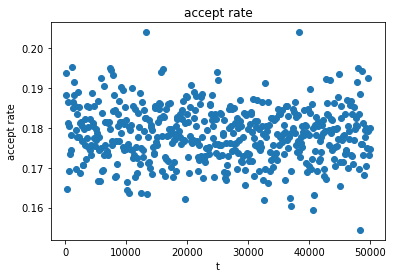

In [38]:
d = 30
para_topic = [np.zeros(d),0.1,np.eye(d)/3*d, 3*d]
randomT(7, 11, 3, np.ones(7), 1, para_topic, d, 50, 50000, 0.01,1)

In [39]:
def randomT2(k0, k1, nlabel, alpha, b, para_topic, d, N, mtime, desired_error, draw_plot=0):
    dg = k0 + k1 
    ntopic = nlabel*k0+k1
    T = []
    for i in range(nlabel):
        tem1 = np.block([
            [np.zeros((k0*i,k0+k1))],
            [np.eye(k0), np.zeros((k0, k1))],
            [np.zeros((k0*(nlabel-i-1),k0+k1))],
            [np.zeros((k1,k0)), np.eye(k1)]
        ])
        tem = np.random.rand(ntopic,dg) + tem1
        for j in range(dg):
            tem[:,j] *= 1/sum(tem[:,j])
        T.append(tem)

    rho, a, X, Y, U, G, s_inv, mu = data_generator(alpha, b, para_topic, T, N)

    
    G_hat, a_rate, errors = gibbs_g(X, Y, T, rho, a, s_inv, mu, G, mtime, desired_error)
    
    print("average error of g is:", errors[-1])
    if draw_plot:
        fig1 = plt.figure()
        ax = Axes3D(fig1)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c =Y)
        plt.title("data visualization")
        plt.show()
        U1 = np.array([np.dot(T[Y[i]], G_hat[i]) for i in range(N)])
        estimateU = sns.heatmap(np.dot(U1,U1.T))
        plt.title("estimated membership")
        plt.show()
        trueU = sns.heatmap(np.dot(U,U.T))
        plt.title("true membership")
        plt.show()
        time = len(a_rate)
        plt.scatter([i*100 for i in range(1, time+1)], errors)
        plt.title("estimation error")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()
        plt.scatter([i*100 for i in range(1, time+1)], a_rate)
        plt.title("accept rate")
        plt.xlabel("t")
        plt.ylabel("accept rate")
        plt.show()

In [40]:
d = 20
randomT2(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01)
randomT2(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
randomT2(2, 5, 3, np.ones(7), 0.1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
randomT2(2, 5, 3, np.ones(7), 10, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# randomT2(2, 5, 5, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# randomT2(5, 5, 5, np.ones(10), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)

average error of g is: 0.737143898996473
average error of g is: 0.8416381010788856
average error of g is: 0.6933762793481588
average error of g is: 1.622273345545866


In [43]:
d = 30
randomT2(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01)
randomT2(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
randomT2(2, 5, 3, np.ones(7), 0.1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# randomT2(2, 5, 3, np.ones(7), 10, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# randomT2(2, 5, 5, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# randomT2(5, 5, 5, np.ones(10), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)

average error of g is: 0.7958702830664888
average error of g is: 0.5862068131822991
average error of g is: 0.4886224828798199


In [44]:
d = 50
randomT2(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 5000, 0.01)
randomT2(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
randomT2(2, 5, 3, np.ones(7), 0.1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# randomT2(2, 5, 3, np.ones(7), 10, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# randomT2(2, 5, 5, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)
# randomT2(5, 5, 5, np.ones(10), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 2*d], d, 50, 5000, 0.01)

average error of g is: 0.6686359551448564
average error of g is: 0.49973822057712225
average error of g is: 1.742874560983914


average error of g is: 0.7448349527110348


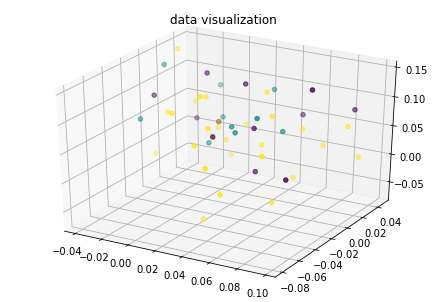

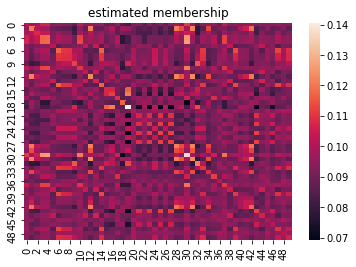

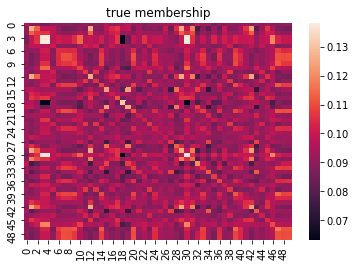

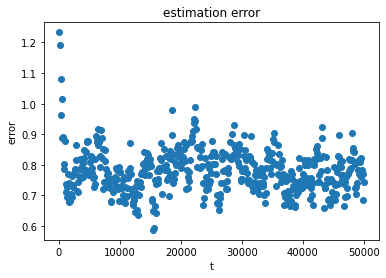

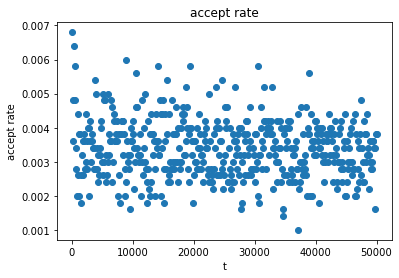

In [46]:
d = 30
randomT2(2, 5, 3, np.ones(7), 1, [np.zeros(d),0.1,np.eye(d)/3*d, 3*d], d, 50, 50000, 0.01,1)